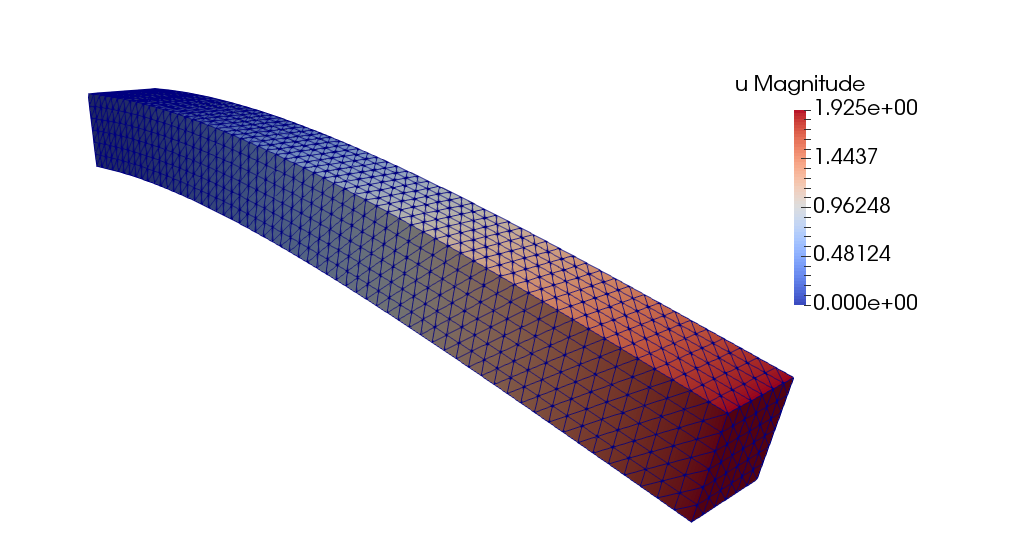

In [1]:
using JuAFEM
using Tensors
using TimerOutputs
using UnicodePlots
const to = TimerOutput();

In [2]:
import Base.flatten

In [3]:
hex = false
geoshape = hex ? Hexahedron : Tetrahedron
refshape = hex ? RefCube    : RefTetrahedron
order = hex? 2 : 1

1

In [4]:
const dim = 3
corner1 = Vec{dim}((0.0, 0.0, 0.0))
corner2 = Vec{dim}((10.0, 1.0, 1.0))
grid = generate_grid(geoshape, (60, 6, 6), corner1, corner2);
# Extract the left boundary
addnodeset!(grid, "clamped", x -> norm(x[1]) ≈ 0.0);

In [5]:
# Interpolations and values
interpolation_space = Lagrange{dim, refshape, 1}()
quadrature_rule = QuadratureRule{dim, refshape}(order)
cellvalues = CellVectorValues(quadrature_rule, interpolation_space);
facevalues = FaceVectorValues(QuadratureRule{dim-1, refshape}(order), interpolation_space);

In [6]:
# DofHandler
dh = DofHandler(grid)
push!(dh, :u, dim) # Add a displacement field
close!(dh)

DofHandler
  Fields:
    u dim: 3
  Total dofs: 8967
  Dofs per cell: 12

In [7]:
@time K = create_sparsity_pattern(dh);
fill!(K.nzval, 1.0);
spy(K)

  0.228741 seconds (105.41 k allocations: 70.145 MB, 13.50% gc time)


                     Sparsity Pattern
        ┌──────────────────────────────────────────┐    
      1 │⢿⣷⣄⠀⠀⠀⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ > 0
        │⠀⠙⢿⣷⣄⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ < 0
        │⠀⠀⠀⠙⢿⣷⠀⠀⠀⠙⢿⣷⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
        │⢿⣷⣄⠀⠀⠀⢿⣷⣄⠀⠀⠀⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
        │⠀⠙⢿⣷⣄⠀⠀⠙⢿⣷⣄⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
        │⠀⠀⠀⠙⢿⣷⠀⠀⠀⠙⢿⣷⠀⠀⠀⠙⢿⣷⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
        │⠀⠀⠀⠀⠀⠀⢿⣷⣄⠀⠀⠀⢿⣷⣄⠀⠀⠀⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
        │⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠙⢿⣷⣄⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
        │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⠀⠀⠀⠙⢿⣷⠀⠀⠀⠙⢿⣷⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
        │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢿⣷⣄⠀⠀⠀⢿⣷⣄⠀⠀⠀⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
        │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠙⢿⣷⣄⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
        │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⠀⠀⠀⠙⢿⣷⠀⠀⠀⠙⢿⣷⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
        │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢿⣷⣄⠀⠀⠀⢿⣷⣄⠀⠀⠀⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
        │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠙⢿⣷⣄⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀│    
        │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⠀⠀⠀⠙⢿⣷⠀⠀⠀⠙⢿⣷⠀⠀⠀⠀⠀⠀│    
        │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢿⣷⣄⠀⠀⠀⢿⣷⣄⠀⠀⠀⢿⣷⣄⠀⠀

In [8]:
# Boundaryconditions
dbc = DirichletBoundaryConditions(dh)
# Add a homogenoush boundary condition on the "clamped" edge
add!(dbc, :u, getnodeset(grid, "clamped"), (x,t) -> [0.0, 0.0, 0.0], collect(1:dim))
close!(dbc)
t = 0.0
update!(dbc, t)

In [9]:
# Create the stiffness tensor
E = 200e9
ν = 0.3
λ = E*ν / ((1+ν) * (1 - 2ν))
μ = E / (2(1+ν))
δ(i,j) = i == j ? 1.0 : 0.0
g(i,j,k,l) = λ*δ(i,j)*δ(k,l) + μ*(δ(i,k)*δ(j,l) + δ(i,l)*δ(j,k))
C = SymmetricTensor{4, dim}(g);

In [10]:
function doassemble{dim}(cellvalues::CellVectorValues{dim}, facevalues::FaceVectorValues{dim}, 
                         K::SparseMatrixCSC, grid::Grid, dh::DofHandler, C::SymmetricTensor{4, dim})

    
    f = zeros(ndofs(dh))
    assembler = start_assemble(K, f)
    
    n_basefuncs = getnbasefunctions(cellvalues)
    global_dofs = zeros(Int, ndofs_per_cell(dh))

    fe = zeros(n_basefuncs) # Local force vector
    Ke = zeros(n_basefuncs, n_basefuncs) # Local stiffness mastrix
    
    t = Vec{3}((0.0, 1e8, 0.0)) # Traction vector
    b = Vec{3}((0.0, 0.0, 0.0)) # Body force
    ɛ = [zero(SymmetricTensor{2, dim}) for i in 1:n_basefuncs]
    @inbounds for (cellcount, cell) in enumerate(CellIterator(dh))
        @timeit to "assem" begin
        fill!(Ke, 0)
        fill!(fe, 0)
        
        reinit!(cellvalues, cell)
        for q_point in 1:getnquadpoints(cellvalues)
            for i in 1:n_basefuncs
                ɛ[i] = symmetric(shape_gradient(cellvalues, q_point, i)) 
            end
            dΩ = getdetJdV(cellvalues, q_point)
            for i in 1:n_basefuncs
                δu = shape_value(cellvalues, q_point, i)
                fe[i] += (δu ⋅ b) * dΩ
                ɛC = ɛ[i] ⊡ C
                for j in 1:n_basefuncs
                    Ke[i, j] += (ɛC ⊡ ɛ[j]) * dΩ
                end
            end
        end
        
        for face in 1:nfaces(cell)
            if onboundary(cell, face) && (cellcount, face) ∈ getfaceset(grid, "right")
                reinit!(facevalues, cell, face)
                for q_point in 1:getnquadpoints(facevalues)
                    dΓ = getdetJdV(facevalues, q_point)
                    for i in 1:n_basefuncs
                        δu = shape_value(facevalues, q_point, i)
                        fe[i] += (δu ⋅ t) * dΓ
                    end
                end
            end
        end
        celldofs!(global_dofs, cell)
        assemble!(assembler, fe, Ke, global_dofs)
        end # timer
    end
    return K, f
end

doassemble (generic function with 1 method)

In [18]:
reset_timer!(to)
K, f = doassemble(cellvalues, facevalues, K, grid, dh, C);
print_timer(to; linechars = :ascii)

 ------------------------------------------------------------------
                           Time                   Allocations      
                   ----------------------   -----------------------
 Tot / % measured:     42.0ms / 92.5%           4.32MiB / 87.0%    

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ------------------------------------------------------------------
 assem      10.8k   38.9ms   100%  3.60μs   3.76MiB  100%      365B
 ------------------------------------------------------------------

In [19]:
# Modify K and f such that K \ f gives correct boundary conditions
@time apply!(K, f, dbc)

  0.003126 seconds (12 allocations: 3.172 KB)


In [20]:
@time u = cholfact(Symmetric(K)) \ f;

  0.112682 seconds (63 allocations: 45.675 MB, 8.30% gc time)


In [14]:
# Save file
vtkfile = vtk_grid("cantilever", dh, u)
vtk_save(vtkfile)

1-element Array{String,1}:
 "cantilever.vtu"

In [15]:
Base.Test.@test maximum(u)  ≈ 1.919600482922295
println("Cantilever successful")

Cantilever successful
